# Тонкая настройка модели gpt-2 (в маленьком размере) для задачи определения сгенерированных большими языковыми моделями текстов

Для работы использовался следующий [датасет](https://www.kaggle.com/datasets/sunilthite/llm-detect-ai-generated-text-dataset)

## Импорт необходимых зависимостей и настройка окружения

In [1]:
import os
os.environ['CUDA_LAUNCH_BLOCKING'] = '1'

In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import gc

In [4]:
import torch
import torch.nn as nn

from torch.optim import AdamW
from torch.utils.data import Dataset, DataLoader

In [5]:
import transformers
from transformers import GPT2LMHeadModel, GPT2Tokenizer

In [6]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, roc_curve, auc, confusion_matrix

In [7]:
from core.utils import *
from core.dataset import AITextDetectionDataset
from core.model import *

Установим значение seed для воспроизводимости экспериментов

In [8]:
init_random_seed(42)

In [9]:
data_path = 'data'

## Загрузка и первичный анализ данных

In [10]:
essays = pd.read_csv(f"{data_path}/Training_Essay_Data.csv")
essays.drop_duplicates(subset=['text'], inplace=True)
essays.sample(10)

,text,generated
21645,There is no definitive answer when it comes to...,1
15447,"When someone is looking for advice, they might...",1
16359,According to the text I think is a good idea t...,0
23888,The debate over whether nations should suspend...,1
12734,"Dear our state Senator,\n\nI am writing to you...",0
27450,The fierce power of the sun has been guiding h...,1
9274,The techology called the Facial Action Coding ...,0
11610,"Dear, state senator i strongly feel that we sh...",0
18112,The idea of creating a new menu for the cafete...,0
22401,"Nowadays, senior high school students are unde...",1


In [11]:
print(f"Количество записей в полном наборе данных: {essays.shape[0]}")

Количество записей в полном наборе данных: 27340


Установим читаемые метки для классов

In [12]:
types_map = {
    0: 'Human written',
    1: 'Generated'
}

In [13]:
essays["type"] = essays["generated"].apply(lambda x: types_map[x])
essays.sample(10)

,text,generated,type
1231,"""Congestionwas down 60% in the capital of fran...",0,Human written
25119,The impact of technology on modern education i...,1,Generated
1001,The process of the electing the president is a...,0,Human written
22690,I agree with the prediction that in twenty yea...,1,Generated
10295,Twenty five years ago when NASA's Viking 1 spa...,0,Human written
10970,The faces that appear on mars is probably made...,0,Human written
6619,What the author was suggesting when he was say...,0,Human written
9072,The Facial Action Coding System (FACS) could b...,0,Human written
82,Advantages of Limiting Car Usage\n\nLimiting c...,1,Generated
6055,Should we study venus or throw away the idea b...,0,Human written


Построим круговую диаграмму для отображения соотношения классов в наборе данных

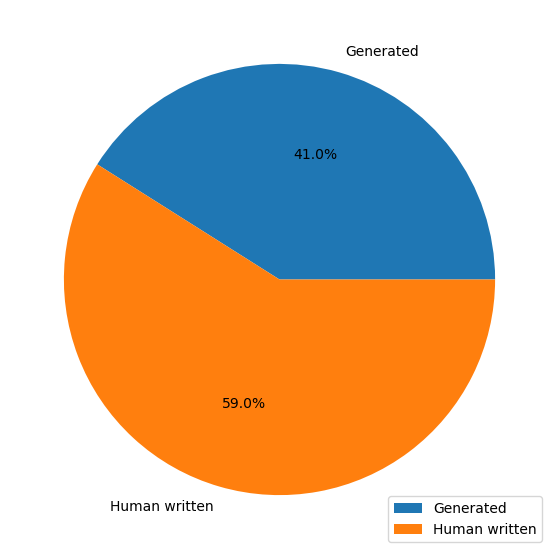

In [14]:
labels_counts = essays.groupby('type').agg(count = ('type', 'count'))
labels_counts.plot.pie(figsize=(7, 7), subplots=True, autopct='%1.1f%%')
plt.ylabel('')
plt.legend(loc='lower right')
plt.show()

Как видно, явный дисбаланс классов не наблюдается, поэтому необходимости использования стратегий сэмплирования для достижения баланса нет

## Подготовка модели к дообучению

Определим устройство, на котором будет происходить дообучение модели

In [15]:
device = ('cuda' if torch.cuda.is_available() else 'cpu')
device

'cuda'

Загрузим веса модели с помощью библиотеки `Transformers`

In [16]:
pretrained_model_name_or_path = 'gpt2'

In [17]:
gpt = GPT2LMHeadModel.from_pretrained(pretrained_model_name_or_path)
tokenizer = GPT2Tokenizer.from_pretrained(pretrained_model_name_or_path)

In [18]:
gpt

GPT2LMHeadModel(
  (transformer): GPT2Model(
    (wte): Embedding(50257, 768)
    (wpe): Embedding(1024, 768)
    (drop): Dropout(p=0.1, inplace=False)
    (h): ModuleList(
      (0-11): 12 x GPT2Block(
        (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (attn): GPT2Attention(
          (c_attn): Conv1D()
          (c_proj): Conv1D()
          (attn_dropout): Dropout(p=0.1, inplace=False)
          (resid_dropout): Dropout(p=0.1, inplace=False)
        )
        (ln_2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (mlp): GPT2MLP(
          (c_fc): Conv1D()
          (c_proj): Conv1D()
          (act): NewGELUActivation()
          (dropout): Dropout(p=0.1, inplace=False)
        )
      )
    )
    (ln_f): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
  )
  (lm_head): Linear(in_features=768, out_features=50257, bias=False)
)

Отключим градиент для параметров модели, поскольку будем дообучать только последний линейный слой, который добавим позже (применим стратегию [Transfer learning](https://chanbong.github.io/2021/06/01/transfer_learning.html))

In [19]:
for param in gpt.parameters():
    param.requires_grad = False

In [20]:
num_labels = essays.generated.nunique()
num_labels

2

Заменим последний линейный слой модели на линейный слой, содержащий количество выходов, соответствующее количеству классов согласно задаче

In [21]:
gpt.lm_head = nn.Linear(gpt.config.hidden_size, num_labels)
gpt = gpt.to(device)
gpt

GPT2LMHeadModel(
  (transformer): GPT2Model(
    (wte): Embedding(50257, 768)
    (wpe): Embedding(1024, 768)
    (drop): Dropout(p=0.1, inplace=False)
    (h): ModuleList(
      (0-11): 12 x GPT2Block(
        (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (attn): GPT2Attention(
          (c_attn): Conv1D()
          (c_proj): Conv1D()
          (attn_dropout): Dropout(p=0.1, inplace=False)
          (resid_dropout): Dropout(p=0.1, inplace=False)
        )
        (ln_2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (mlp): GPT2MLP(
          (c_fc): Conv1D()
          (c_proj): Conv1D()
          (act): NewGELUActivation()
          (dropout): Dropout(p=0.1, inplace=False)
        )
      )
    )
    (ln_f): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
  )
  (lm_head): Linear(in_features=768, out_features=2, bias=True)
)

Определим максимальный размер контекста модели чтобы применить к входным данным операции `padding` и `truncation`

In [22]:
max_size_of_tokenized_text = gpt.config.n_ctx
max_size_of_tokenized_text

1024

## Подготовка данных

Выделим признаки и целевую переменную

In [23]:
X = essays.text
y = essays.generated

Выделим из датасета тренировочную и тестовую выборки (в соотношении 80/20)

In [24]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

Если в образце данных меньше токенов, чем максимальное воспринимаемое моделью количество - дополним его токеном конца текста

In [25]:
tokenizer.pad_token_id = 50256
print(tokenizer.pad_token)

<|endoftext|>


In [26]:
train_dataset = AITextDetectionDataset(X_train, y_train, tokenizer, device=device, max_length=max_size_of_tokenized_text)
test_dataset = AITextDetectionDataset(X_test, y_test, tokenizer, device=device, max_length=max_size_of_tokenized_text)

free_memory()

In [27]:
print(f"Количество записей в тренировочном наборе данных: {len(train_dataset)}")
print(f"Количество записей в тестовом наборе данных: {len(test_dataset)}")

Количество записей в тренировочном наборе данных: 21872
Количество записей в тестовом наборе данных: 5468


## Обучение модели

In [28]:
batch_size = 32
num_epochs = 5

In [29]:
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

In [30]:
optimizer = AdamW(gpt.lm_head.parameters(), lr=0.01, weight_decay=1e-4)
criterion = nn.CrossEntropyLoss()

In [31]:
%%time
loss_history, train_history, f1_history = train_model(gpt, 
                                          train_loader, 
                                          criterion, 
                                          optimizer, num_epochs, device=device)

Average loss: 0.11506738513708115, Train accuracy: 0.9630577907827359, Train f1 score: 0.9551260690880818
Average loss: 0.023634048178792, Train accuracy: 0.9925932699341624, Train f1 score: 0.990961838875251
Average loss: 0.019348949193954468, Train accuracy: 0.9945592538405267, Train f1 score: 0.9933552962197777
Average loss: 0.01702679507434368, Train accuracy: 0.9947421360643746, Train f1 score: 0.993584379358438
Average loss: 0.013100982643663883, Train accuracy: 0.9960223116313094, Train f1 score: 0.9951480675924377
CPU times: total: 2h 19min 54s
Wall time: 2h 21min 50s


In [32]:
free_memory()

Построим графики изменения значений функции потерь, точности и F1-score по эпохам обучения

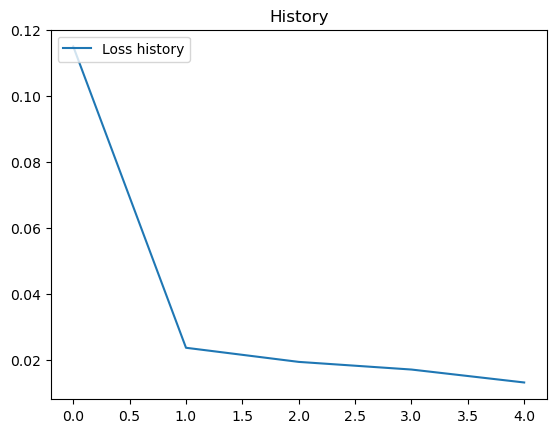

In [33]:
plt.title("History")
plt.plot(loss_history, label="Loss history")
plt.legend(loc="upper left")
plt.show()

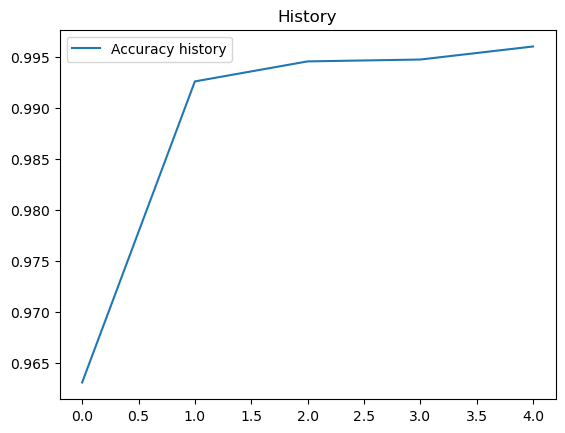

In [34]:
plt.title("History")
plt.plot(train_history, label="Accuracy history")
plt.legend(loc="upper left")
plt.show()

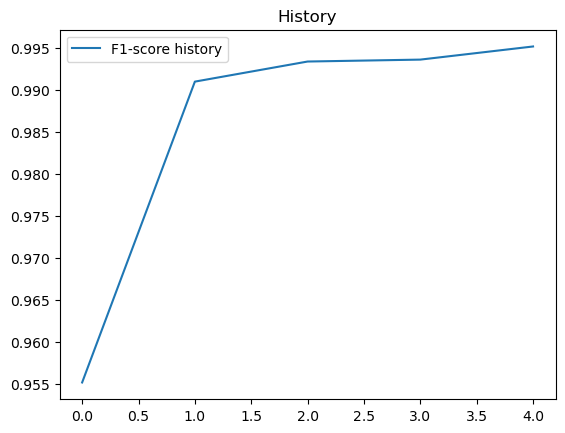

In [35]:
plt.title("History")
plt.plot(f1_history, label="F1-score history")
plt.legend(loc="upper left")
plt.show()

## Тестирование модели

In [36]:
test_loader = DataLoader(test_dataset, batch_size=batch_size)

Получим предсказания модели в формате меток и вероятностей положительного класса

In [37]:
ground_truth, predictions, probabilities = get_model_predictions(model=gpt, data_loader=test_loader, device=device)

Вычислим точность, f1-score, ROC AUC

In [38]:
accuracy = accuracy_score(ground_truth, predictions)
print(f"Test accuracy is {accuracy}")

Test accuracy is 0.9369056327724945


In [39]:
f1 = f1_score(ground_truth, predictions)
print(f"Test F1-score is {f1}")

Test F1-score is 0.9285862140343614


In [40]:
roc_auc = roc_auc_score(ground_truth, probabilities)
print(f"Test ROC-AUC score is {roc_auc}")

Test ROC-AUC score is 0.9995942304994654


Построим матрицу ошибок модели

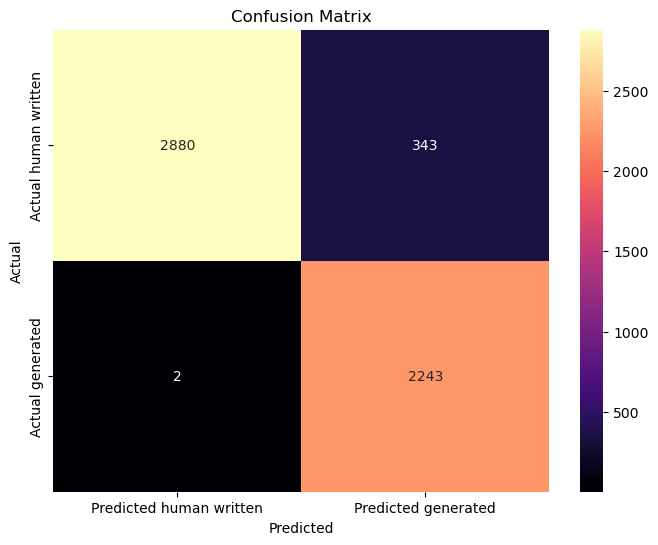

In [41]:
cm = confusion_matrix(ground_truth, predictions)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='magma', cbar=True, xticklabels=['Predicted human written', 'Predicted generated'], 
            yticklabels=['Actual human written', 'Actual generated'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

Построим ROC кривую

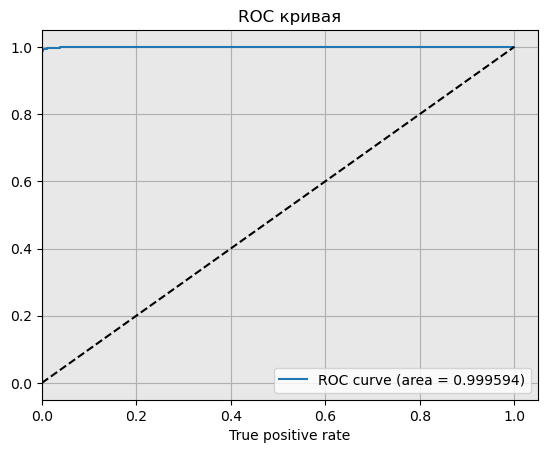

In [42]:
fpr, tpr, thresholds = roc_curve(ground_truth, probabilities)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, label="ROC curve (area = %0.6f)" % (roc_auc))
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.xlim([0.0, 1.05])
plt.xlabel('False positive rate')
plt.xlabel('True positive rate')
plt.title('ROC РєСЂРёРІР°СЏ')
plt.legend(loc='lower right')
plt.grid()
plt.gca().patch.set_facecolor('lightgrey')
plt.gca().patch.set_alpha(0.5)
plt.show()

## Сохранение, загрузка и повторное тестирование модели

In [43]:
torch.save(gpt, "models/gpt2_for_ai_text_detection.pth")

In [44]:
ai_texts_detector = torch.load("models/gpt2_for_ai_text_detection.pth")
ai_texts_detector = ai_texts_detector.to(device)
ai_texts_detector

GPT2LMHeadModel(
  (transformer): GPT2Model(
    (wte): Embedding(50257, 768)
    (wpe): Embedding(1024, 768)
    (drop): Dropout(p=0.1, inplace=False)
    (h): ModuleList(
      (0-11): 12 x GPT2Block(
        (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (attn): GPT2Attention(
          (c_attn): Conv1D()
          (c_proj): Conv1D()
          (attn_dropout): Dropout(p=0.1, inplace=False)
          (resid_dropout): Dropout(p=0.1, inplace=False)
        )
        (ln_2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (mlp): GPT2MLP(
          (c_fc): Conv1D()
          (c_proj): Conv1D()
          (act): NewGELUActivation()
          (dropout): Dropout(p=0.1, inplace=False)
        )
      )
    )
    (ln_f): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
  )
  (lm_head): Linear(in_features=768, out_features=2, bias=True)
)

In [45]:
%%time
loaded_model_ground_truth, \
loaded_model_predictions, \
loaded_model_probabilities = get_model_predictions(model=ai_texts_detector, data_loader=test_loader, device=device)

CPU times: total: 7min
Wall time: 7min 1s


In [46]:
loaded_model_accuracy = accuracy_score(loaded_model_ground_truth, loaded_model_predictions)
print(f"Loaded model accuracy is {accuracy}")

Loaded model accuracy is 0.9369056327724945


In [47]:
loaded_model_f1 = f1_score(loaded_model_ground_truth, loaded_model_predictions)
print(f"Loaded model F1-score is {loaded_model_f1}")

Loaded model F1-score is 0.9285862140343614


In [48]:
loaded_model_roc_auc = roc_auc_score(loaded_model_ground_truth, loaded_model_probabilities)
print(f"Loaded model ROC-AUC score is {loaded_model_roc_auc}")

Loaded model ROC-AUC score is 0.9995942304994654
